In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=47a54f123f6fd1b77dd5956c3c94d80d59f2a8257a84be13425a3d1f33dcee78
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [0]:
# Importing All the Libraries
import pyspark
from pyspark import sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, sum
import pyspark.ml
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, sqrt
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import max
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC

# Pandas Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report ,confusion_matrix,accuracy_score,roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


     |████████████████████████████████| 235 kB 30.5 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-229b1ef7-5403-44ef-bbdf-7e191f09acce/bin/python -m pip install --upgrade pip' command.


In [0]:
# Define the variables used for creating connection strings
adlsAccountName = "creditcardpredection"
adlsContainerName = "creditdataset"
adlsFolderName = "team14"
mountPoint = "/mnt/final_mount"

# Application (Client) ID
applicationId = dbutils.secrets.get(scope="secret02", key="appid")

# Application (Client) Secret Key
authenticationKey = dbutils.secrets.get(scope="secret02", key="clientsecret")

# Directory (Tenant) ID
tenantId = dbutils.secrets.get(scope="secret02", key="tenantid")

endpoint = "https://login.microsoftonline.com/" + tenantId + "/oauth2/token"
source = "abfss://" + adlsContainerName + "@" + adlsAccountName + ".dfs.core.windows.net/" + adlsFolderName

# Connecting using Service Principal secrets and OAuth
configs = {
    "fs.azure.account.auth.type": "OAuth",
    "fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
    "fs.azure.account.oauth2.client.id": applicationId,
    "fs.azure.account.oauth2.client.secret": authenticationKey,
    "fs.azure.account.oauth2.client.endpoint": endpoint
}


# Mount only if the directory is not already mounted
if not any(mount.mountPoint == mountPoint for mount in dbutils.fs.mounts()):
    # Mount Azure Data Lake Storage Gen2 to the specified mount point
    dbutils.fs.mount(
        source=source,
        mount_point=mountPoint,
        extra_configs=configs
    )

In [0]:
%fs
ls "/mnt/final_mount"

path,name,size,modificationTime
dbfs:/mnt/final_mount/fraudTrain.csv,fraudTrain.csv,351238196,1692799660000
dbfs:/mnt/final_mount/gold/,gold/,0,1692952806000
dbfs:/mnt/final_mount/silver/,silver/,0,1692949800000


In [0]:
os.getcwd()
dbutils.fs.mounts()

Out[6]: [MountInfo(mountPoint='/databricks-datasets', source='databricks-datasets', encryptionType=''),
 MountInfo(mountPoint='/Volumes', source='UnityCatalogVolumes', encryptionType=''),
 MountInfo(mountPoint='/databricks/mlflow-tracking', source='databricks/mlflow-tracking', encryptionType=''),
 MountInfo(mountPoint='/databricks-results', source='databricks-results', encryptionType=''),
 MountInfo(mountPoint='/mnt/final_mount', source='abfss://creditdataset@creditcardpredection.dfs.core.windows.net/team14', encryptionType=''),
 MountInfo(mountPoint='/databricks/mlflow-registry', source='databricks/mlflow-registry', encryptionType=''),
 MountInfo(mountPoint='/Volume', source='DbfsReserved', encryptionType=''),
 MountInfo(mountPoint='/mnt/final_mount2', source='abfss://creditdataset@creditcardpredection.dfs.core.windows.net/team14', encryptionType=''),
 MountInfo(mountPoint='/volumes', source='DbfsReserved', encryptionType=''),
 MountInfo(mountPoint='/', source='DatabricksRoot', encryp

In [0]:
# List all currently mounted paths
mounts = dbutils.fs.mounts()

# Iterate through the list of mounts and print their details
for mount in mounts:
    print("Mount Name:", mount.source)
    print("Mount Point:", mount.mountPoint)
    print("-------------------")


Mount Name: databricks-datasets
Mount Point: /databricks-datasets
-------------------
Mount Name: UnityCatalogVolumes
Mount Point: /Volumes
-------------------
Mount Name: databricks/mlflow-tracking
Mount Point: /databricks/mlflow-tracking
-------------------
Mount Name: databricks-results
Mount Point: /databricks-results
-------------------
Mount Name: abfss://creditdataset@creditcardpredection.dfs.core.windows.net/team14
Mount Point: /mnt/final_mount
-------------------
Mount Name: databricks/mlflow-registry
Mount Point: /databricks/mlflow-registry
-------------------
Mount Name: DbfsReserved
Mount Point: /Volume
-------------------
Mount Name: abfss://creditdataset@creditcardpredection.dfs.core.windows.net/team14
Mount Point: /mnt/final_mount2
-------------------
Mount Name: DbfsReserved
Mount Point: /volumes
-------------------
Mount Name: DatabricksRoot
Mount Point: /
-------------------
Mount Name: DbfsReserved
Mount Point: /volume
-------------------


In [0]:
mounted_path = "/mnt/final_mount"
full_mounted_path = "/dbfs" + mounted_path  # Full DBFS path
os.chdir(full_mounted_path)


In [0]:
os.getcwd()

Out[9]: '/dbfs/mnt/final_mount'

In [0]:
# Creating spark session and reading file

spark = SparkSession.builder.master("local").appName("CreditCard").getOrCreate()
df = spark.read.csv("/mnt/final_mount/fraudTrain.csv", header=True, inferSchema = True)

# reading file in pandas for eda
eda_df = pd.read_csv("fraudTrain.csv")

In [0]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [0]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [0]:
#checking spark information
spark

- WorkFlow
* Data Prep
* Feature Engineering
* Build Model
* Evaluate

In [0]:
# checking type of dataframe
type(df)

pyspark.sql.dataframe.DataFrame

# EDA

In [0]:
# checking directory
#os.getcwd()

'/content'

In [0]:
# changing directory
#os.chdir(r'/content/drive/MyDrive/Dataset')

In [0]:
# printing first 5 rows of dataframe
eda_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [0]:
unique_job_count = eda_df['job'].nunique()
print(unique_job_count)

494


In [0]:
eda_df['cc_num'].nunique()

983

In [0]:
eda_df['merchant'].nunique()

693

In [0]:
eda_df['trans_date_trans_time'].min()

'2019-01-01 00:00:18'

In [0]:
eda_df['trans_date_trans_time'].max()

'2020-06-21 12:13:37'

In [0]:
eda_df.corr()

<ipython-input-12-a0de98e0bcef>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  eda_df.corr()


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
Unnamed: 0,1.000000,0.000386,-0.000251,0.000709,0.000602,-0.000676,-0.001678,0.998971,0.000541,-0.000671,-0.004767
cc_num,0.000386,1.000000,0.001769,0.041459,-0.059271,-0.048278,-0.008991,0.000354,-0.058942,-0.048252,-0.000981
amt,-0.000251,0.001769,1.000000,0.001843,-0.001926,-0.000187,0.005818,-0.000293,-0.001873,-0.000151,0.219404
zip,0.000709,0.041459,0.001843,1.000000,-0.114290,-0.909732,0.078467,0.000670,-0.113561,-0.908924,-0.002162
lat,0.000602,-0.059271,-0.001926,-0.114290,1.000000,-0.015533,-0.155730,0.000632,0.993592,-0.015509,0.001894
long,-0.000676,-0.048278,-0.000187,-0.909732,-0.015533,1.000000,-0.052715,-0.000642,-0.015452,0.999120,0.001721
city_pop,-0.001678,-0.008991,0.005818,0.078467,-0.155730,-0.052715,1.000000,-0.001714,-0.154781,-0.052687,0.002136
unix_time,0.998971,0.000354,-0.000293,0.000670,0.000632,-0.000642,-0.001714,1.000000,0.000561,-0.000635,-0.005078
merch_lat,0.000541,-0.058942,-0.001873,-0.113561,0.993592,-0.015452,-0.154781,0.000561,1.000000,-0.015431,0.001741
merch_long,-0.000671,-0.048252,-0.000151,-0.908924,-0.015509,0.999120,-0.052687,-0.000635,-0.015431,1.000000,0.001721


<ipython-input-13-163dab1eca20>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(eda_df.corr(),annot=True).set_title('Correlation')


Text(0.5, 1.0, 'Correlation')

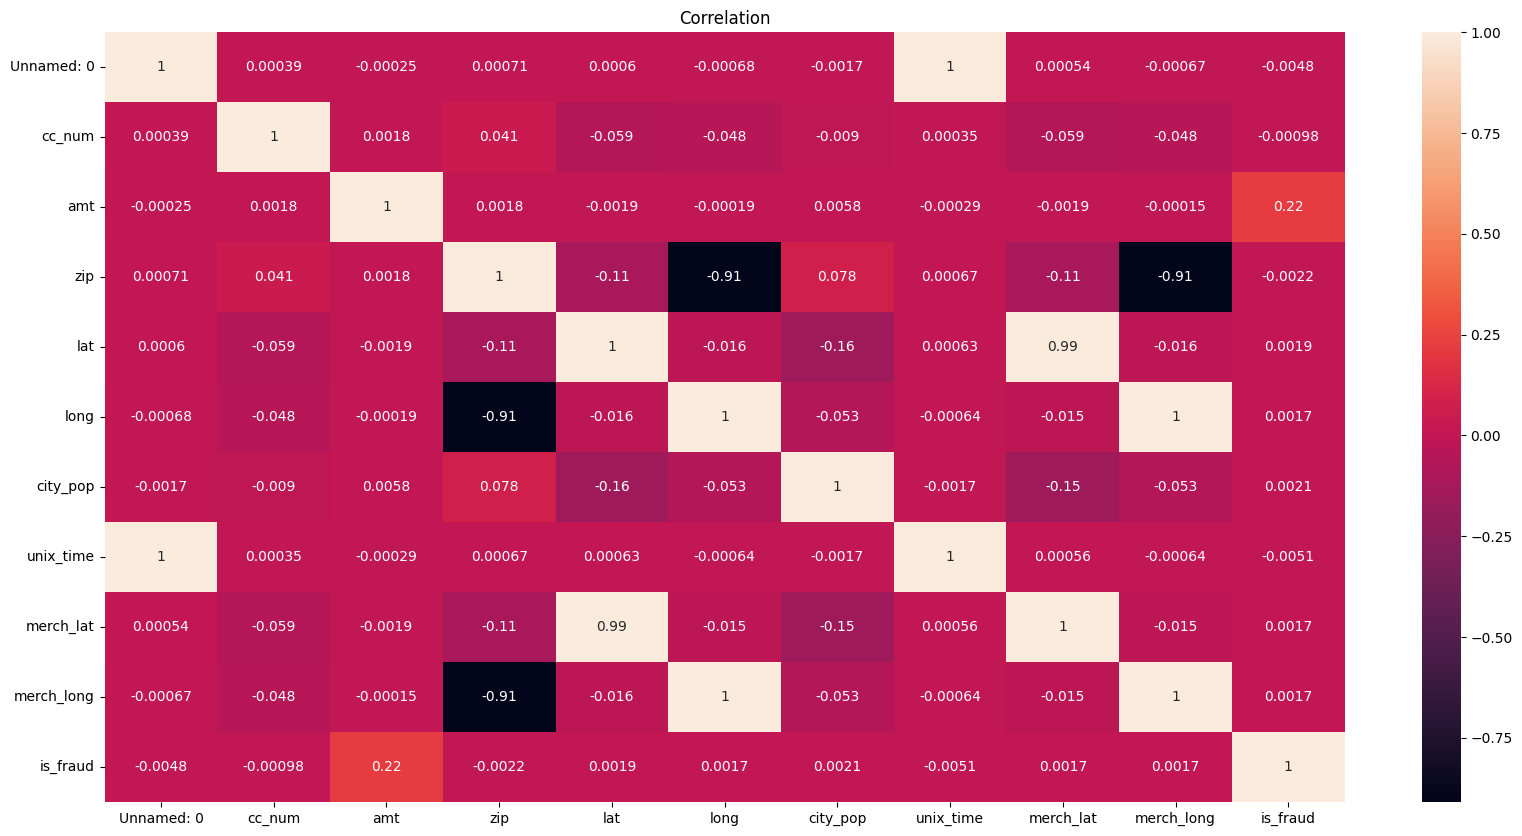

In [0]:
# For Checking Correlation between Columns using Heatmap
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(eda_df.corr(),annot=True).set_title('Correlation')

In [0]:
value_counts = eda_df['is_fraud'].value_counts()
print(value_counts)

0    1289169
1       7506
Name: is_fraud, dtype: int64


In [0]:
# Univariate analysis for categories :- Here, we are doing Categorical Univariate Analysis in

<Axes: >

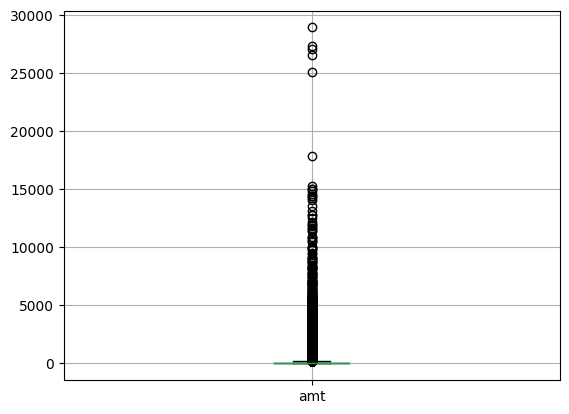

In [0]:
# outliers for amount
eda_df['amt'].boxplot()

In [0]:
eda_df['amt'].nunique()

52928

In [0]:
eda_df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [0]:
eda_df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

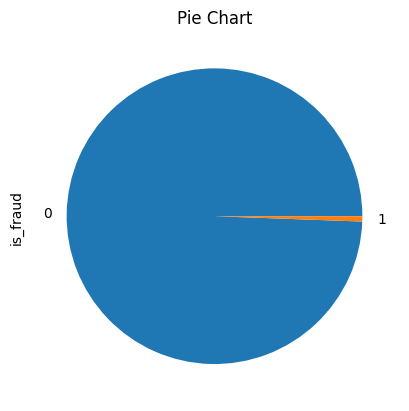

In [0]:
eda_df['is_fraud'].value_counts().plot(kind='pie')
plt.title('Pie Chart')
plt.show()

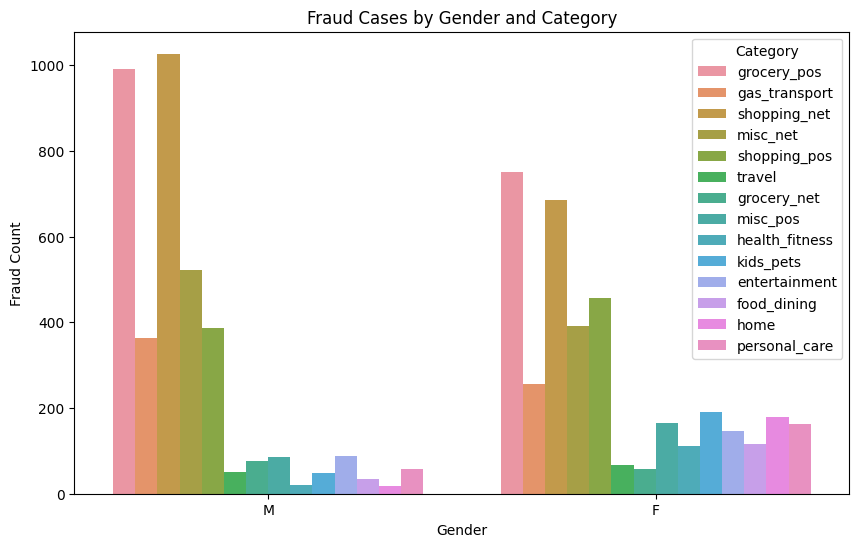

In [0]:
# Filter only fraud cases
fraud_df = eda_df[eda_df['is_fraud'] == 1]

# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

sns.countplot(data=fraud_df, x='gender', hue='category')
plt.title('Fraud Cases by Gender and Category')
plt.xlabel('Gender')
plt.ylabel('Fraud Count')
plt.legend(title='Category', loc='upper right')
plt.xticks(rotation=0)
plt.show()

In [0]:
eda_df['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

In [0]:
eda_df['merchant'].nunique()

693

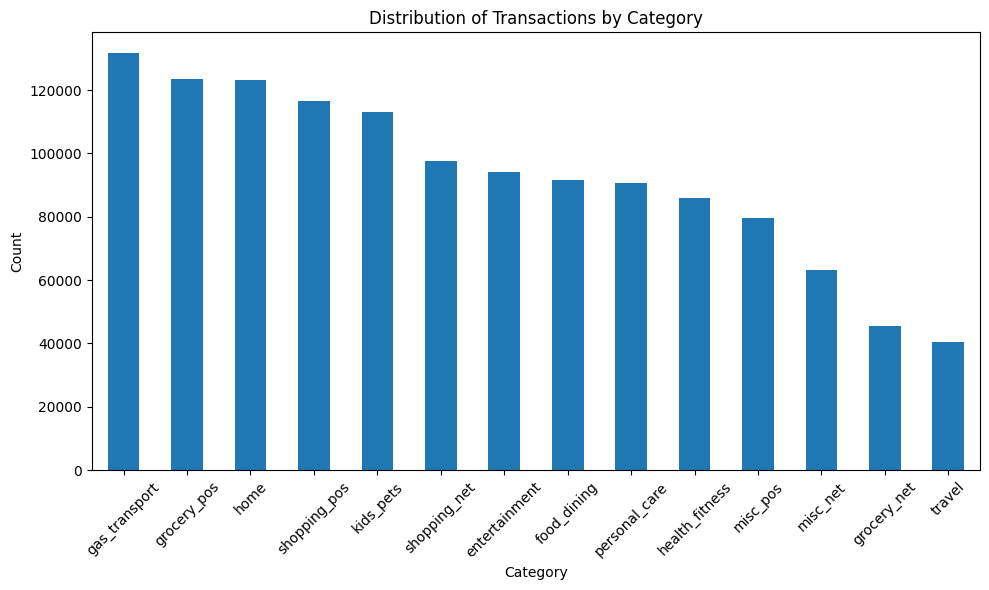

In [0]:
# Draw histogram for 'category'
plt.figure(figsize=(10, 6))
eda_df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-35-65a4e6be2bc6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(eda_df['amt'])


<Axes: xlabel='amt', ylabel='Density'>

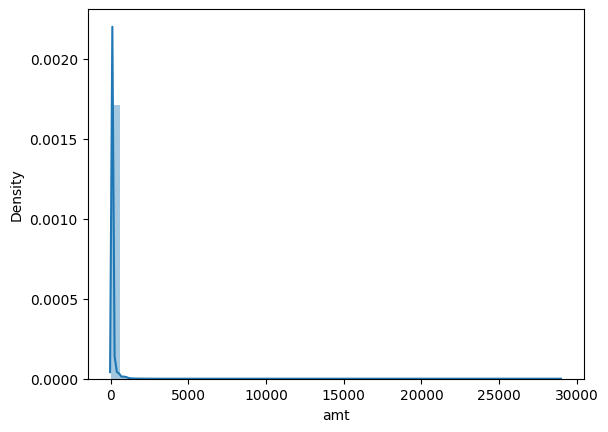

In [0]:
sns.distplot(eda_df['amt'])

# Pyspark

In [0]:
df.head(3)

[Row(_c0=0, trans_date_trans_time=datetime.datetime(2019, 1, 1, 0, 0, 18), cc_num=2703186189652095, merchant='fraud_Rippin, Kub and Mann', category='misc_net', amt=4.97, first='Jennifer', last='Banks', gender='F', street='561 Perry Cove', city='Moravian Falls', state='NC', zip=28654, lat=36.0788, long=-81.1781, city_pop=3495, job='Psychologist, counselling', dob=datetime.date(1988, 3, 9), trans_num='0b242abb623afc578575680df30655b9', unix_time=1325376018, merch_lat=36.011293, merch_long=-82.048315, is_fraud=0),
 Row(_c0=1, trans_date_trans_time=datetime.datetime(2019, 1, 1, 0, 0, 44), cc_num=630423337322, merchant='fraud_Heller, Gutmann and Zieme', category='grocery_pos', amt=107.23, first='Stephanie', last='Gill', gender='F', street='43039 Riley Greens Suite 393', city='Orient', state='WA', zip=99160, lat=48.8878, long=-118.2105, city_pop=149, job='Special educational needs teacher', dob=datetime.date(1978, 6, 21), trans_num='1f76529f8574734946361c461b024d99', unix_time=1325376044, me

In [0]:
df.dtypes

[('_c0', 'int'),
 ('trans_date_trans_time', 'timestamp'),
 ('cc_num', 'bigint'),
 ('merchant', 'string'),
 ('category', 'string'),
 ('amt', 'double'),
 ('first', 'string'),
 ('last', 'string'),
 ('gender', 'string'),
 ('street', 'string'),
 ('city', 'string'),
 ('state', 'string'),
 ('zip', 'int'),
 ('lat', 'double'),
 ('long', 'double'),
 ('city_pop', 'int'),
 ('job', 'string'),
 ('dob', 'date'),
 ('trans_num', 'string'),
 ('unix_time', 'int'),
 ('merch_lat', 'double'),
 ('merch_long', 'double'),
 ('is_fraud', 'int')]

In [0]:
df.show(1,0)

+---+---------------------+----------------+--------------------------+--------+----+--------+-----+------+--------------+--------------+-----+-----+-------+--------+--------+-------------------------+----------+--------------------------------+----------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num          |merchant                  |category|amt |first   |last |gender|street        |city          |state|zip  |lat    |long    |city_pop|job                      |dob       |trans_num                       |unix_time |merch_lat|merch_long|is_fraud|
+---+---------------------+----------------+--------------------------+--------+----+--------+-----+------+--------------+--------------+-----+-----+-------+--------+--------+-------------------------+----------+--------------------------------+----------+---------+----------+--------+
|0  |2019-01-01 00:00:18  |2703186189652095|fraud_Rippin, Kub and Mann|misc_net|4.97|Jennifer|Banks|F     |561 Perry Cove|Moravian Falls|NC

In [0]:
df.count()

1296675

In [0]:
df.select('city').distinct().count()

894

In [0]:
df.select('cc_num').distinct().count()

983

In [0]:
# from pyspark.sql.functions import col, round
# # Calculate the percentage of null values in each column
# null_per_col = df.select([(round((col(c).isNull().sum() / df.count()) * 100, 2)).alias(c) for c in df.columns])

# # Show the percentages of null values
# null_per_col.show()

In [0]:
# type(df_pyspark.select('Name').show())
df.select(['merchant','Category']).show()

+--------------------+-------------+
|            merchant|     Category|
+--------------------+-------------+
|fraud_Rippin, Kub...|     misc_net|
|fraud_Heller, Gut...|  grocery_pos|
|fraud_Lind-Buckridge|entertainment|
|fraud_Kutch, Herm...|gas_transport|
| fraud_Keeling-Crist|     misc_pos|
|fraud_Stroman, Hu...|gas_transport|
|fraud_Rowe-Vander...|  grocery_net|
|fraud_Corwin-Collins|gas_transport|
|    fraud_Herzog Ltd|     misc_pos|
|fraud_Schoen, Kup...|  grocery_pos|
|fraud_Rutherford-...|  grocery_pos|
|fraud_Kerluke-Abs...| shopping_net|
|   fraud_Lockman Ltd|  grocery_pos|
|     fraud_Kiehn Inc|  grocery_pos|
|   fraud_Beier-Hyatt| shopping_pos|
|fraud_Schmidt and...| shopping_net|
|fraud_Lebsack and...|     misc_net|
|  fraud_Mayert Group| shopping_pos|
|fraud_Konopelski,...|  food_dining|
|fraud_Schultz, Si...|  grocery_pos|
+--------------------+-------------+
only showing top 20 rows



In [0]:
df.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [0]:
# Citywise Customer Count
df.groupBy('City').agg(countDistinct('cc_num').alias('citycount')).show()

+-----------------+---------+
|             City|citycount|
+-----------------+---------+
|             Jelm|        1|
|            Tyler|        1|
|          Palermo|        1|
|Kingsford Heights|        1|
|          Whigham|        1|
|      Springfield|        2|
|          Tyaskin|        1|
|           Corona|        1|
|      Woods Cross|        1|
|      New Memphis|        1|
|           Auburn|        1|
|  North Las Vegas|        1|
|       Georgetown|        2|
|          Phoenix|        2|
|            Rhame|        1|
|          Acworth|        1|
|       Plainfield|        1|
|         Falconer|        1|
|          Harwood|        1|
|     West Decatur|        1|
+-----------------+---------+
only showing top 20 rows



In [0]:
# Citywise Customer Count in Descending Order
df.groupBy('City').agg(countDistinct('cc_num').alias('citycount')).orderBy(desc('citycount')).show()

+-------------+---------+
|         City|citycount|
+-------------+---------+
|       Dallas|        5|
|      Detroit|        4|
|New York City|        4|
|      Houston|        4|
|    Allentown|        3|
|  San Antonio|        3|
|        Utica|        3|
|       Camden|        3|
|    San Diego|        3|
|      Arcadia|        3|
|   Washington|        3|
|       Naples|        3|
|       Warren|        3|
|     Lakeland|        3|
|   Huntsville|        3|
|        Tulsa|        3|
|      Oakland|        2|
| Indianapolis|        2|
|       Albany|        2|
|  Clarksville|        2|
+-------------+---------+
only showing top 20 rows



In [0]:
df.select(min("trans_date_trans_time")).show()

+--------------------------+
|min(trans_date_trans_time)|
+--------------------------+
|       2019-01-01 00:00:18|
+--------------------------+



In [0]:
# Count the number of rows
row_count = df.count()
print("Number of rows:", row_count)

# Count the number of columns
column_count = len(df.columns)
print("Number of columns:", column_count)

Number of rows: 1296675
Number of columns: 23


In [0]:
from pyspark.sql.functions import col, sum

In [0]:
# Check for null values in the DataFrame
# Using isNull()
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



In [0]:
# Using isNotNull()
not_null_counts = df.select([sum(col(c).isNotNull().cast("int")).alias(c) for c in df.columns])
not_null_counts.show()

+-------+---------------------+-------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+-------+---------+---------+---------+----------+--------+
|    _c0|trans_date_trans_time| cc_num|merchant|category|    amt|  first|   last| gender| street|   city|  state|    zip|    lat|   long|city_pop|    job|    dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+-------+---------------------+-------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+-------+---------+---------+---------+----------+--------+
|1296675|              1296675|1296675| 1296675| 1296675|1296675|1296675|1296675|1296675|1296675|1296675|1296675|1296675|1296675|1296675| 1296675|1296675|1296675|  1296675|  1296675|  1296675|   1296675| 1296675|
+-------+---------------------+-------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--

In [0]:
# Get the summary statistics for numeric columns including null values. The summary() function provides a more concise summary of statistics for all the columns in the DataFrame.
# including both numerical and categorical columns.
df.summary().show()

# Display the summary DataFrame
#summary_df.show()

+-------+-----------------+--------------------+-------------------+-------------+------------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+
|summary|              _c0|              cc_num|           merchant|     category|               amt|  first|   last| gender|              street|   city|  state|               zip|               lat|              long|         city_pop|               job|           trans_num|           unix_time|         merch_lat|        merch_long|            is_fraud|
+-------+-----------------+--------------------+-------------------+-------------+------------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------

### Feature Enngineering
* Numerical Values
* Vectorisation
* Scaling

In [0]:
df.select('dob').distinct()

DataFrame[dob: date]

In [0]:
df.show(5)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

In [0]:
dir(pyspark.ml)

['Estimator',
 'Model',
 'Pipeline',
 'PipelineModel',
 'PredictionModel',
 'Predictor',
 'TorchDistributor',
 'Transformer',
 'UnaryTransformer',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'classification',
 'clustering',
 'common',
 'evaluation',
 'feature',
 'fpm',
 'image',
 'linalg',
 'param',
 'pipeline',
 'recommendation',
 'regression',
 'stat',
 'torch',
 'tree',
 'tuning',
 'util',
 'wrapper']

In [0]:
df.show(4)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

In [0]:
# Count the occurrences of 'is_fraud' values
fraud_counts = df.groupBy("is_fraud").count()

# Show the counts
fraud_counts.show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   7506|
|       0|1289169|
+--------+-------+



In [0]:
# The sqrt function from the pyspark.sql.functions module is used to calculate the square root. Replace "lat", "merch_lat", "long", and "merch_long"
# with the actual column names corresponding to latitude and longitude in your DataFrame.


# Calculate the distance column
df = df.withColumn(
    "distance",
    sqrt((col("lat") - col("merch_lat")) ** 2 + (col("long") - col("merch_long")) ** 2)
)

# Show the updated DataFrame schema
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- distance: double (nullable = true)



In [0]:
# Define a UDF to extract the hour from a timestamp
def pull_hour(ts):
    return ts.hour

# Register the UDF
pull_hour_udf = udf(pull_hour, returnType=IntegerType())

# Add a new column with the extracted hour
df = df.withColumn("hour", pull_hour_udf("trans_date_trans_time"))

# Show the updated DataFrame schema
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- hour: integer (nullable = true)



In [0]:
df.stat.corr('amt','distance')

-0.0012316624871780443

In [0]:
df.stat.cov('amt','is_fraud')

2.668391390485785

In [0]:
freq = df.stat.freqItems(['amt','is_fraud'],0.3)

In [0]:
freq.collect()

[Row(amt_freqItems=[4.67, 8.65, 57.46], is_fraud_freqItems=[1, 0])]

In [0]:
# Define a window specification
window_spec = Window.partitionBy("cc_num").orderBy("unix_time").rangeBetween(-2629743, 0)

# Calculate the sum of transaction amounts in the last 30 days
df = df.withColumn("history_30", F.sum("amt").over(window_spec))

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- history_30: double (nulla

In [0]:
# Calculate the interaction effect with the transaction amount
df = df.withColumn("interaction_30", F.col("history_30") / F.col("amt"))

# Show the resulting DataFrame
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- history_30: double (nulla

In [0]:
max_value = df.agg(max('history_30')).collect()[0][0]

print("Maximum value:", max_value)


Maximum value: 43964.31999999996


In [0]:
# Selected COlumns for Modelling
selected_columns = [
    "amt",
    "city_pop",
    "is_fraud",
    "distance",
    "hour",
    "history_30",
    "Interaction_30"
]

# Select the desired columns
df = df.select(*selected_columns)

# Show the updated DataFrame schema
df.printSchema()

root
 |-- amt: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- history_30: double (nullable = true)
 |-- Interaction_30: double (nullable = true)



In [0]:
df.show(5)

+-----+--------+--------+-------------------+----+------------------+------------------+
|  amt|city_pop|is_fraud|           distance|hour|        history_30|    Interaction_30|
+-----+--------+--------+-------------------+----+------------------+------------------+
| 7.27|    1645|       0|  1.286702903523965|  12|              7.27|               1.0|
|52.94|    1645|       0|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|
|82.08|    1645|       0|0.26475619184637994|   8|            142.29|1.7335526315789473|
|34.79|    1645|       0| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|
|27.18|    1645|       0| 0.8653860231561501|  13|            204.26| 7.515084621044886|
+-----+--------+--------+-------------------+----+------------------+------------------+
only showing top 5 rows



In [0]:
df.select('city_pop').distinct().show()

+--------+
|city_pop|
+--------+
|  124967|
|     471|
|    1645|
|    2142|
|     463|
|  545147|
|    1507|
|     540|
|     737|
|   23727|
|   47211|
|   32891|
|   14075|
|    4161|
|   12626|
|    1139|
|     516|
|    1352|
|    1143|
|      85|
+--------+
only showing top 20 rows



## **Pyspark** Scaling

In [0]:
# List of columns to assemble
feature_columns = ["amt","city_pop","distance","hour","history_30","Interaction_30"]

In [0]:
# Create a VectorAssembler instance
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


# Transform the DataFrame using the VectorAssembler
assembled_df = assembler.transform(df)

# Show the resulting DataFrame with the new 'features' column
assembled_df.show()

+------+--------+--------+-------------------+----+------------------+------------------+--------------------+
|   amt|city_pop|is_fraud|           distance|hour|        history_30|    Interaction_30|            features|
+------+--------+--------+-------------------+----+------------------+------------------+--------------------+
|  7.27|    1645|       0|  1.286702903523965|  12|              7.27|               1.0|[7.27,1645.0,1.28...|
| 52.94|    1645|       0|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|[52.94,1645.0,0.9...|
| 82.08|    1645|       0|0.26475619184637994|   8|            142.29|1.7335526315789473|[82.08,1645.0,0.2...|
| 34.79|    1645|       0| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|[34.79,1645.0,0.7...|
| 27.18|    1645|       0| 0.8653860231561501|  13|            204.26| 7.515084621044886|[27.18,1645.0,0.8...|
|  6.87|    1645|       0| 0.7409533703175989|  13|            211.13|30.732168850072778|[6.87,1645.0,0.74...|
|

In [0]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit and transform the scaler on your data
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Show the scaled DataFrame
scaled_df.show()

+------+--------+--------+-------------------+----+------------------+------------------+--------------------+--------------------+
|   amt|city_pop|is_fraud|           distance|hour|        history_30|    Interaction_30|            features|     scaled_features|
+------+--------+--------+-------------------+----+------------------+------------------+--------------------+--------------------+
|  7.27|    1645|       0|  1.286702903523965|  12|              7.27|               1.0|[7.27,1645.0,1.28...|[-0.3934792552145...|
| 52.94|    1645|       0|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|[52.94,1645.0,0.9...|[-0.1086044516269...|
| 82.08|    1645|       0|0.26475619184637994|   8|            142.29|1.7335526315789473|[82.08,1645.0,0.2...|[0.07316151676678...|
| 34.79|    1645|       0| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|[34.79,1645.0,0.7...|[-0.2218183269305...|
| 27.18|    1645|       0| 0.8653860231561501|  13|            204.26| 7.515

In [0]:
scaled_df.select("scaled_features").show(1)

+--------------------+
|     scaled_features|
+--------------------+
|[-0.3934792552145...|
+--------------------+
only showing top 1 row



In [0]:
final_df = scaled_df.select(col('is_fraud').alias('label'),'scaled_features')

In [0]:
final_df.select(col('label')).distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



In [0]:
final_df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [0]:
train, test = final_df.randomSplit([0.8, 0.2], seed = 123)

print("Train Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Train Dataset Count: 1036689
Test Dataset Count: 259986


In [0]:
train.show(5)

+-----+--------------------+
|label|     scaled_features|
+-----+--------------------+
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
+-----+--------------------+
only showing top 5 rows



In [0]:
test.show(5)

+-----+--------------------+
|label|     scaled_features|
+-----+--------------------+
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
|    0|[-0.4325895030466...|
+-----+--------------------+
only showing top 5 rows



#**Logistic Regression**
# (without balancing)

In [0]:
lr=LogisticRegression (featuresCol = 'scaled_features', labelCol ='label', maxIter=5)
lrModel=lr.fit(train)

In [0]:
pred_lr=lrModel.transform(test)
pred_lr.select('label', 'prediction', 'probability').show(5, False)

Exception ignored in: <function JavaWrapper.__del__ at 0x7a5f41a34af0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


+-----+----------+-------------------------------------------+
|label|prediction|probability                                |
+-----+----------+-------------------------------------------+
|0    |0.0       |[0.9999999997808888,2.1911117364936672E-10]|
|0    |0.0       |[0.9999756083961681,2.439160383194139E-5]  |
|0    |0.0       |[0.9999886666037187,1.1333396281343333E-5] |
|0    |0.0       |[0.996988438761351,0.0030115612386489854]  |
|0    |0.0       |[0.9999886429723097,1.1357027690284127E-5] |
+-----+----------+-------------------------------------------+
only showing top 5 rows



In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_lr)

print("Accuracy:", accuracy)


Accuracy: 0.9935727308393529


In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator.evaluate(pred_lr)

print("Recall:", recall)

Recall: 0.8261065664158124


In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedPrecision")

# Calculate precision
precision = evaluator.evaluate(pred_lr)

print("Precision:", precision)

Precision: 0.9881243170927014


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1" )

f1_score = evaluator.evaluate(pred_lr)
print("F1 score:", f1_score)

F1 score: 0.9908410341197901


In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(pred_lr)
print("Area Under ROC Curve (AUC) = %g" % auc)

Area Under ROC Curve (AUC) = 0.826107


## Decision Tree

In [0]:

tree = DecisionTreeClassifier(labelCol="label",featuresCol="scaled_features",maxDepth=5,maxBins=32)
tree_model = tree.fit(train)

In [0]:
# Create predictions on test data
pred_dt= tree_model.transform(test)
pred_dt.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+------------------------------------------+
|label|prediction|probability                               |
+-----+----------+------------------------------------------+
|0    |0.0       |[0.9985346397381331,0.0014653602618669708]|
|0    |0.0       |[0.9985346397381331,0.0014653602618669708]|
|0    |0.0       |[0.9985346397381331,0.0014653602618669708]|
|0    |0.0       |[0.9985346397381331,0.0014653602618669708]|
|0    |0.0       |[0.9985346397381331,0.0014653602618669708]|
+-----+----------+------------------------------------------+
only showing top 5 rows



In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_dt)
print("Accuracy = " + str(accuracy))

Accuracy = 0.9949228035355749


In [0]:
evaluator_dt = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator_dt.evaluate(pred_dt)

print("Recall:", recall)

Recall: 0.9949228035355749


In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedPrecision")

# Calculate precision
precision = evaluator.evaluate(pred_dt)

print("Precision:", precision)

Precision: 0.9949228035355749


In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc_dt = evaluator.evaluate(pred_dt)
print("Area Under ROC Curve (AUC) = %g" % auc_dt)

Area Under ROC Curve (AUC) = 0.136778


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1" )

f1_score = evaluator.evaluate(pred_dt)
print("F1 score:", f1_score)

F1 score: 0.9939939708504238


## **Random** Forest

In [0]:
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [0]:
rf = RandomForestClassifier(numTrees=10, maxDepth=5,featuresCol="scaled_features",labelCol="label", seed=1)
model = rf.fit(train)

In [0]:
predictions_rf = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy = " + str(accuracy))

Accuracy = 0.9948420299554591


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(predictions_rf)
print("F1 score:", f1_score)

F1 score: 0.9938010700402655


In [0]:
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator_rf.evaluate(predictions_rf)

print("Recall:", recall)

Recall: 0.9948420299554591


In [0]:
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedPrecision")

# Calculate precision
precision = evaluator.evaluate(predictions_rf)

print("Precision:", precision)

Precision: 0.9938010700402655


## **SVM**

In [0]:

lsvc = LinearSVC(featuresCol="scaled_features",maxIter=10, regParam=0.1)
model = lsvc.fit(train)

In [0]:
# Make predictions on the test data
predictions_svm = model.transform(test)

In [0]:
# Evaluate the model using the MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
accuracy = evaluator.evaluate(predictions_svm)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.991078
Test Error = 0.00892236


In [0]:

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

f1_score = evaluator.evaluate(predictions_svm)
print("F1 score:", f1_score)

F1 score: 0.5


In [0]:
evaluator_svm = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="re")

# Calculate recall
recall = evaluator_rf.evaluate(predictions_svm)

print("Recall:", recall)

Recall: 0.9881271185761882


In [0]:
# Balancing of Data

In [0]:
df.show()

+------+--------+--------+-------------------+----+------------------+------------------+
|   amt|city_pop|is_fraud|           distance|hour|        history_30|    Interaction_30|
+------+--------+--------+-------------------+----+------------------+------------------+
|  7.27|    1645|       0|  1.286702903523965|  12|              7.27|               1.0|
| 52.94|    1645|       0|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|
| 82.08|    1645|       0|0.26475619184637994|   8|            142.29|1.7335526315789473|
| 34.79|    1645|       0| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|
| 27.18|    1645|       0| 0.8653860231561501|  13|            204.26| 7.515084621044886|
|  6.87|    1645|       0| 0.7409533703175989|  13|            211.13|30.732168850072778|
|  8.43|    1645|       0|  0.295637182629308|  17|            219.56|26.045077105575327|
|117.11|    1645|       0| 0.6644436186291502|  13|            336.67|2.8748185466655283|
| 26.74|  

In [0]:
df.show()

+------+--------+--------+-------------------+----+------------------+------------------+
|   amt|city_pop|is_fraud|           distance|hour|        history_30|    Interaction_30|
+------+--------+--------+-------------------+----+------------------+------------------+
|  7.27|    1645|       0|  1.286702903523965|  12|              7.27|               1.0|
| 52.94|    1645|       0|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|
| 82.08|    1645|       0|0.26475619184637994|   8|            142.29|1.7335526315789473|
| 34.79|    1645|       0| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|
| 27.18|    1645|       0| 0.8653860231561501|  13|            204.26| 7.515084621044886|
|  6.87|    1645|       0| 0.7409533703175989|  13|            211.13|30.732168850072778|
|  8.43|    1645|       0|  0.295637182629308|  17|            219.56|26.045077105575327|
|117.11|    1645|       0| 0.6644436186291502|  13|            336.67|2.8748185466655283|
| 26.74|  

In [0]:
pandas_df = df.toPandas()

In [0]:
pandas_df.head()

,amt,city_pop,is_fraud,distance,hour,history_30,Interaction_30
0,7.27,1645,0,1.286703,12,7.27,1.000000
1,52.94,1645,0,0.997045,8,60.21,1.137325
2,82.08,1645,0,0.264756,8,142.29,1.733553
3,34.79,1645,0,0.790685,12,177.08,5.089968
4,27.18,1645,0,0.865386,13,204.26,7.515085


In [0]:
pandas_df.count()

amt               1296675
city_pop          1296675
is_fraud          1296675
distance          1296675
hour              1296675
history_30        1296675
Interaction_30    1296675
dtype: int64

In [0]:
x = pandas_df.drop('is_fraud',axis=1)
x
y = pandas_df['is_fraud']
y

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int32

In [0]:

# Assuming X_train and y_train are your original data and labels
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_oversampled, y_oversampled = smote.fit_resample(x, y)

In [0]:
X_oversampled

,amt,city_pop,distance,hour,history_30,Interaction_30
0,7.270000,1645,1.286703,12,7.270000,1.000000
1,52.940000,1645,0.997045,8,60.210000,1.137325
2,82.080000,1645,0.264756,8,142.290000,1.733553
3,34.790000,1645,0.790685,12,177.080000,5.089968
4,27.180000,1645,0.865386,13,204.260000,7.515085
...,...,...,...,...,...,...
1933748,841.623325,595,0.754073,16,4063.217256,4.839003
1933749,769.026544,214520,0.851521,23,8869.559587,11.557252
1933750,318.643654,1110,1.193200,3,10347.994551,32.489880
1933751,931.988497,139650,0.761251,22,8274.140114,9.866822


In [0]:
y_oversampled = y_oversampled.to_frame().rename(columns={0: 'is_fraud'})
print(y_oversampled)

         is_fraud
0               0
1               0
2               0
3               0
4               0
...           ...
1933748         1
1933749         1
1933750         1
1933751         1
1933752         1

[1933753 rows x 1 columns]


In [0]:
import pandas as pd
pandas_over_df = pd.concat([X_oversampled, y_oversampled], axis=1)

In [0]:
pandas_over_df

,amt,city_pop,distance,hour,history_30,Interaction_30,is_fraud
0,7.270000,1645,1.286703,12,7.270000,1.000000,0
1,52.940000,1645,0.997045,8,60.210000,1.137325,0
2,82.080000,1645,0.264756,8,142.290000,1.733553,0
3,34.790000,1645,0.790685,12,177.080000,5.089968,0
4,27.180000,1645,0.865386,13,204.260000,7.515085,0
...,...,...,...,...,...,...,...
1933748,841.623325,595,0.754073,16,4063.217256,4.839003,1
1933749,769.026544,214520,0.851521,23,8869.559587,11.557252,1
1933750,318.643654,1110,1.193200,3,10347.994551,32.489880,1
1933751,931.988497,139650,0.761251,22,8274.140114,9.866822,1


# **Modelling with Pandas**

In [0]:
# Scaling

sc = StandardScaler()
# Independent Features
x = sc.fit_transform(pandas_over_df.drop('is_fraud',axis=1))
x

array([[-0.65169242, -0.2897853 ,  1.94127933, -0.14118982, -1.68441879,
        -0.41509284],
       [-0.51334903, -0.2897853 ,  0.86066537, -0.68181441, -1.67229556,
        -0.41496555],
       [-0.42507826, -0.2897853 , -1.87125798, -0.68181441, -1.65349928,
        -0.41441291],
       ...,
       [ 0.29151942, -0.29150725,  1.5924509 , -1.35759514,  0.68360179,
        -0.38590477],
       [ 2.14946119,  0.15439765, -0.0190051 ,  1.21037166,  0.20869019,
        -0.40687416],
       [ 1.50701892,  1.76916625, -0.28432438, -1.76306359, -0.60985711,
        -0.40904767]])

In [0]:
# Dependent Feature
y = pandas_over_df.iloc[:,-1].values
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [0]:
# Data Splitting
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)

# **Logistic Regression**

In [0]:
log_model = LogisticRegression()
log_model.fit(x_train,y_train)

LogisticRegression()

In [0]:
log_pred=log_model.predict(x_test)
log_pred

array([0, 0, 1, ..., 1, 1, 0], dtype=int32)

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
accuracy_score(y_test,log_pred)

0.8948409209848606

In [0]:
confusion_matrix(y_test, log_pred)

array([[315891,   6942],
       [ 43896, 116710]])

In [0]:
print("="*20)

print("Accuracy Score")
print("*"*20)
print(accuracy_score(y_test,log_pred))

print("="*20)

print("confusion_matrix :")
print("*"*20)
print(confusion_matrix(y_test,log_pred))

print("="*20)

print("classification_report")
print("*"*50)
print(classification_report(y_test,log_pred))

print("="*50)

print(roc_auc_score(y_test,log_pred))
print("ROC CURVE")
print("*"*50)


Accuracy Score
********************
0.8948409209848606
confusion_matrix :
********************
[[315891   6942]
 [ 43896 116710]]
classification_report
**************************************************
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    322833
           1       0.94      0.73      0.82    160606

    accuracy                           0.89    483439
   macro avg       0.91      0.85      0.87    483439
weighted avg       0.90      0.89      0.89    483439

0.8525909009868685
**************************************************


# **Decision Tree**

In [0]:
#Model,Building
classifier = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [0]:
y_pred = classifier.predict(x_test)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [0]:
#Checking the performance of the Matrix
print("confusion_matrix :")
print(confusion_matrix(y_pred,y_test))

confusion_matrix :
[[316803   3778]
 [  6030 156828]]


In [0]:
print("classification_report")
print(classification_report(y_pred,y_test))

classification_report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    320581
           1       0.98      0.96      0.97    162858

    accuracy                           0.98    483439
   macro avg       0.98      0.98      0.98    483439
weighted avg       0.98      0.98      0.98    483439



In [0]:
print("accuracy_score")
print(accuracy_score(y_pred,y_test))

accuracy_score
0.9797120215787307


In [0]:
print("="*20)

print("Accuracy Score")
print("*"*20)
print(accuracy_score(y_pred,y_test))

print("="*20)

print("confusion_matrix :")
print("*"*20)
print(confusion_matrix(y_pred,y_test))

print("="*20)

print("classification_report")
print("*"*50)
print(classification_report(y_pred,y_test))

print("="*50)

print(roc_auc_score(y_pred,y_test))
print("ROC CURVE")
print("*"*50)


Accuracy Score
********************
0.9797120215787307
confusion_matrix :
********************
[[316803   3778]
 [  6030 156828]]
classification_report
**************************************************
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    320581
           1       0.98      0.96      0.97    162858

    accuracy                           0.98    483439
   macro avg       0.98      0.98      0.98    483439
weighted avg       0.98      0.98      0.98    483439

0.9755945129794019
ROC CURVE
**************************************************


# **Random Forest**

In [0]:
pandas_over_df.head()

,amt,city_pop,distance,hour,history_30,Interaction_30,is_fraud
0,7.27,1645,1.286703,12,7.27,1.000000,0
1,52.94,1645,0.997045,8,60.21,1.137325,0
2,82.08,1645,0.264756,8,142.29,1.733553,0
3,34.79,1645,0.790685,12,177.08,5.089968,0
4,27.18,1645,0.865386,13,204.26,7.515085,0


In [0]:

# Assuming data_with_features is a pandas DataFrame

# Define features and target
X = pandas_over_df.drop("is_fraud", axis=1)
y = pandas_over_df["is_fraud"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Define the Random Forest model
rf = RandomForestClassifier()

# Fit the model to the training data
model = rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)

print("Accuracy:", accuracy)

Accuracy: 0.9887395249139628


In [0]:
print("="*20)

print("Accuracy Score")
print("*"*20)
print(accuracy_score(y_test, y_pred_rf))

print("="*20)

print("confusion_matrix :")
print("*"*20)
print(confusion_matrix(y_test, y_pred_rf))

print("="*20)

print("classification_report")
print("*"*50)
print(classification_report(y_test, y_pred_rf))

print("="*50)

print(roc_auc_score(y_test, y_pred_rf))
print("*"*50)

print(roc_curve(y_test, y_pred_rf))

print("="*50)

In [0]:
type(log_model)

sklearn.linear_model._logistic.LogisticRegression

In [0]:
type(classifier)

sklearn.tree._classes.DecisionTreeClassifier

In [0]:
type(model)

sklearn.ensemble._forest.RandomForestClassifier

# **SVM**

In [0]:



# Split the data into training and testing sets
x_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the Linear SVM model
svm = LinearSVC()

# Fit the model to the training data
model3 = svm.fit(x_train, y_train)

# Make predictions on the testing data
y_pred1 = model3.predict(X_test)



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [0]:
#Checking the performance of the Matrix
print("="*20)

print("Accuracy Score")
print("*"*20)
print(accuracy_score(y_pred1,y_test))

print("="*20)

print("confusion_matrix :")
print("*"*20)
print(confusion_matrix(y_pred1,y_test))

print("="*20)

print("classification_report")
print("*"*50)
print(classification_report(y_pred1,y_test))

print("="*50)


Accuracy Score
********************
0.8688199901228439
confusion_matrix :
********************
[[253592  46509]
 [  4225  82425]]
classification_report
**************************************************
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    300101
           1       0.64      0.95      0.76     86650

    accuracy                           0.87    386751
   macro avg       0.81      0.90      0.84    386751
weighted avg       0.91      0.87      0.88    386751



In [0]:
spark_df = spark.createDataFrame(pandas_over_df)

In [0]:
spark_df.show()

+------+--------+-------------------+----+------------------+------------------+--------+
|   amt|city_pop|           distance|hour|        history_30|    Interaction_30|is_fraud|
+------+--------+-------------------+----+------------------+------------------+--------+
|  7.27|    1645|  1.286702903523965|  12|              7.27|               1.0|       0|
| 52.94|    1645|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|       0|
| 82.08|    1645|0.26475619184637994|   8|            142.29|1.7335526315789473|       0|
| 34.79|    1645| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|       0|
| 27.18|    1645| 0.8653860231561501|  13|            204.26| 7.515084621044886|       0|
|  6.87|    1645| 0.7409533703175989|  13|            211.13|30.732168850072778|       0|
|  8.43|    1645|  0.295637182629308|  17|            219.56|26.045077105575327|       0|
|117.11|    1645| 0.6644436186291502|  13|            336.67|2.8748185466655283|       0|
| 26.74|  

# Pyspark Scaling

In [0]:
# List of columns to assemble
feature_columns = ["amt","city_pop","distance","hour","history_30","Interaction_30"]

In [0]:
# Create a VectorAssembler instance
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


# Transform the DataFrame using the VectorAssembler
assembled_df = assembler.transform(spark_df)

# Show the resulting DataFrame with the new 'features' column
assembled_df.show()

+------+--------+-------------------+----+------------------+------------------+--------+--------------------+
|   amt|city_pop|           distance|hour|        history_30|    Interaction_30|is_fraud|            features|
+------+--------+-------------------+----+------------------+------------------+--------+--------------------+
|  7.27|    1645|  1.286702903523965|  12|              7.27|               1.0|       0|[7.27,1645.0,1.28...|
| 52.94|    1645|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|       0|[52.94,1645.0,0.9...|
| 82.08|    1645|0.26475619184637994|   8|            142.29|1.7335526315789473|       0|[82.08,1645.0,0.2...|
| 34.79|    1645| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|       0|[34.79,1645.0,0.7...|
| 27.18|    1645| 0.8653860231561501|  13|            204.26| 7.515084621044886|       0|[27.18,1645.0,0.8...|
|  6.87|    1645| 0.7409533703175989|  13|            211.13|30.732168850072778|       0|[6.87,1645.0,0.74...|
|

In [0]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit and transform the scaler on your data
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Show the scaled DataFrame
scaled_df.show()

+------+--------+-------------------+----+------------------+------------------+--------+--------------------+--------------------+
|   amt|city_pop|           distance|hour|        history_30|    Interaction_30|is_fraud|            features|     scaled_features|
+------+--------+-------------------+----+------------------+------------------+--------+--------------------+--------------------+
|  7.27|    1645|  1.286702903523965|  12|              7.27|               1.0|       0|[7.27,1645.0,1.28...|[-0.6516922478017...|
| 52.94|    1645|  0.997045441863112|   8|60.209999999999994|1.1373252738949753|       0|[52.94,1645.0,0.9...|[-0.5133489006569...|
| 82.08|    1645|0.26475619184637994|   8|            142.29|1.7335526315789473|       0|[82.08,1645.0,0.2...|[-0.4250781510225...|
| 34.79|    1645| 0.7906847478091352|  12|177.07999999999998| 5.089968381718885|       0|[34.79,1645.0,0.7...|[-0.5683287944751...|
| 27.18|    1645| 0.8653860231561501|  13|            204.26| 7.515084621044

In [0]:

final_over_df = scaled_df.select(col('is_fraud').alias('label'),'scaled_features')

In [0]:
final_over_df.select(col('label')).distinct().show()

+-----+
|label|
+-----+
|    0|
|    1|
+-----+



In [0]:
train, test = final_over_df.randomSplit([0.75, 0.25], seed = 123)
print("Train Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Train Dataset Count: 1449513
Test Dataset Count: 484240


In [0]:
train.show(5)

+-----+--------------------+
|label|     scaled_features|
+-----+--------------------+
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
+-----+--------------------+
only showing top 5 rows



In [0]:
test.show(5)

+-----+--------------------+
|label|     scaled_features|
+-----+--------------------+
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
|    0|[-0.6706853020298...|
+-----+--------------------+
only showing top 5 rows



# **Modelling with Spark**
(with Balancing)

### Logistic Regression

In [0]:
lr=LogisticRegression (featuresCol = 'scaled_features', labelCol ='label', maxIter=5)
lrModel=lr.fit(train)

In [0]:
pred_over_lr=lrModel.transform(test)
pred_over_lr.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.9561297302780503,0.04387026972194974]|
|0    |0.0       |[0.9165718869897577,0.08342811301024233]|
|0    |0.0       |[0.9293705527526835,0.07062944724731646]|
|0    |0.0       |[0.8938847715869961,0.10611522841300391]|
|0    |0.0       |[0.9131436500227655,0.08685634997723446]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(pred_over_lr)
print("Area Under ROC Curve (AUC) = %g" % auc)

Area Under ROC Curve (AUC) = 0.871605


In [0]:
# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator.evaluate(pred_over_lr)

print("Recall:", recall)

Recall: 0.8937592929126053


In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_over_lr)
print("Accuracy = " + str(accuracy))

Accuracy = 0.8937592929126054


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(pred_over_lr)
print("F1 score:", f1_score)

F1 score: 0.8514258207155311


### Decision Tree

In [0]:

tree = DecisionTreeClassifier(labelCol="label",featuresCol="scaled_features",maxDepth=5,maxBins=32)
tree_model = tree.fit(train)

In [0]:
# Create predictions on test data
pred_over_dt= tree_model.transform(test)
pred_over_dt.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.9587643346155763,0.04123566538442369]|
|0    |0.0       |[0.9587643346155763,0.04123566538442369]|
|0    |0.0       |[0.9587643346155763,0.04123566538442369]|
|0    |0.0       |[0.9587643346155763,0.04123566538442369]|
|0    |0.0       |[0.9587643346155763,0.04123566538442369]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [0]:

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')
auroc_dt = evaluator.evaluate(pred_dt, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve (Decision Tree Classifier Regression model): {:.4f}".format(auroc_dt))

Area under ROC Curve (Decision Tree Classifier Regression model): 0.8522


In [0]:
evaluator_dt = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator_dt.evaluate(pred_over_dt)

print("Recall:", recall)

Recall: 0.9158103419791839


In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_over_dt)
print("Accuracy = " + str(accuracy))

Accuracy = 0.9158103419791839


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(pred_over_dt)
print("F1 score:", f1_score)

F1 score: 0.8917929663495394


## Random Forest

In [0]:
rf = RandomForestClassifier(numTrees=10, maxDepth=5,featuresCol="scaled_features",labelCol="label", seed=1)
model = rf.fit(train)

In [0]:
predictions_rf = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy = " + str(accuracy))

Accuracy = 0.9016995704609284


In [0]:
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator_rf.evaluate(predictions_rf)

print("Recall:", recall)

Recall: 0.9016995704609285


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(predictions_rf)
print("F1 score:", f1_score)

F1 score: 0.8684967373960255


##SVM##

In [0]:

lsvc = LinearSVC(featuresCol="scaled_features",maxIter=10, regParam=0.1)
model = lsvc.fit(train)

In [0]:
# Make predictions on the test data
predictions_svm = model.transform(test)

In [0]:
predictionAndLabels = predictions_svm.select("prediction", "label")

# Instantiate the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [0]:
# Evaluate the model using a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")
accuracy = evaluator.evaluate(predictions_svm)

print("Accuracy:", accuracy)

Accuracy: 0.85246732641006


In [0]:
evaluator_svm = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")

# Calculate recall
recall = evaluator_svm.evaluate(predictions_svm)

print("Recall:", recall)

Recall: 0.8301709895919378


In [0]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(predictions_svm)
print("F1 score:", f1_score)

F1 score: 0.7508470608241237
